All frames shape: (1684753, 942)


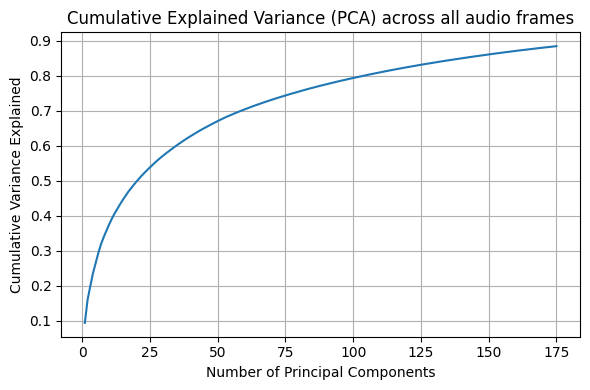


Top 15 features by PCA importance:
256: 0.0256 — embedding[256]
104: 0.0255 — embedding[104]
363: 0.0255 — embedding[363]
518: 0.0254 — embedding[518]
41: 0.0252 — embedding[41]
624: 0.0252 — embedding[624]
420: 0.0252 — embedding[420]
327: 0.0251 — embedding[327]
504: 0.0251 — embedding[504]
580: 0.0251 — embedding[580]
177: 0.0250 — embedding[177]
625: 0.0250 — embedding[625]
137: 0.0250 — embedding[137]
99: 0.0250 — embedding[99]
341: 0.0250 — embedding[341]
27: 0.0249 — embedding[27]
229: 0.0249 — embedding[229]
241: 0.0249 — embedding[241]
283: 0.0249 — embedding[283]
680: 0.0249 — embedding[680]
355: 0.0249 — embedding[355]
571: 0.0248 — embedding[571]
345: 0.0248 — embedding[345]
450: 0.0248 — embedding[450]
755: 0.0248 — embedding[755]
689: 0.0248 — embedding[689]
380: 0.0248 — embedding[380]
288: 0.0248 — embedding[288]
685: 0.0248 — embedding[685]
205: 0.0248 — embedding[205]
2: 0.0248 — embedding[2]
293: 0.0247 — embedding[293]
245: 0.0247 — embedding[245]
210: 0.0247 — emb

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



# === CONFIG ===
features_path = "MLPC2025_dataset/audio_features"
frame_features = []

# === STEP 1: Stack frame-level features from all files ===
for fname in os.listdir(features_path):
    if not fname.endswith(".npz"):
        continue

    try:
        data = np.load(os.path.join(features_path, fname))

        feature_stack = np.concatenate([
            data['embeddings'],                     # (n, 768)
            data['melspectrogram'],                 # (n, 64)
            data['mfcc'],                           # (n, 32)
            data['mfcc_delta'],                     # (n, 32)
            data['mfcc_delta2'],                    # (n, 32)
            data['flatness'],                       # (n, 1)
            data['centroid'],                       # (n, 1)
            data['flux'],                           # (n, 1)
            data['energy'],                         # (n, 1)
            data['power'],                          # (n, 1)
            data['bandwidth'],                      # (n, 1)
            data['contrast'],                       # (n, 7)
            data['zerocrossingrate']                # (n, 1)
        ], axis=1)

        frame_features.append(feature_stack)

    except Exception as e:
        print(f"Error with {fname}: {e}")

all_frames = np.vstack(frame_features)
print("All frames shape:", all_frames.shape)  # Expect (total_frames, 942)
scaler = StandardScaler()
all_frames_std = scaler.fit_transform(all_frames)

# === STEP 2: PCA Analysis ===
pca = PCA(n_components=175)
pca.fit(all_frames_std)

explained = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(explained)+1), explained)
plt.title("Cumulative Explained Variance (PCA) across all audio frames")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Variance Explained")
plt.grid(True)
plt.tight_layout()
plt.show()

# === STEP 3: Feature Importance from PCA Loadings ===
weighted_loadings = np.abs(pca.components_) * pca.explained_variance_ratio_.reshape(-1, 1)
importance_scores = weighted_loadings.sum(axis=0) 
top_indices = np.argsort(importance_scores)[-175:][::-1] 

# === STEP 4: Feature Variance Ranking ===
variances = np.var(all_frames, axis=0)
top_var_indices = np.argsort(variances)[-30:][::-1]

# === STEP 5: Interpretation Helper ===
def interpret_index(idx):
    if idx < 768:
        return f"embedding[{idx}]"
    elif idx < 832:
        return f"mel[{idx - 768}]"
    elif idx < 864:
        return f"mfcc[{idx - 832}]"
    elif idx < 896:
        return f"delta_mfcc[{idx - 864}]"
    elif idx < 928:
        return f"delta2_mfcc[{idx - 896}]"
    elif idx == 928:
        return "flatness"
    elif idx == 929:
        return "centroid"
    elif idx == 930:
        return "flux"
    elif idx == 931:
        return "energy"
    elif idx == 932:
        return "power"
    elif idx == 933:
        return "bandwidth"
    elif 934 <= idx < 941:
        return f"contrast[{idx - 934}]"
    elif idx == 941:
        return "zcr"

print("\nTop 15 features by PCA importance:")
for i in top_indices[:40]:
    print(f"{i}: {importance_scores[i]:.4f} — {interpret_index(i)}")

print("\nTop 15 features by raw variance:")
for i in top_var_indices[:15]:
    print(f"{i}: {variances[i]:.4f} — {interpret_index(i)}")

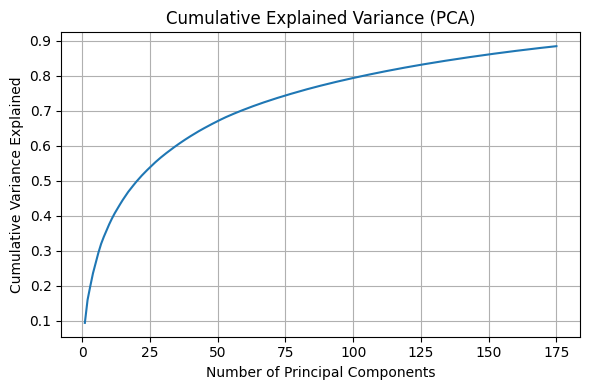

In [2]:
explained = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(explained)+1), explained)
plt.title("Cumulative Explained Variance (PCA)")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Variance Explained")
plt.grid(True)
plt.tight_layout()
plt.savefig("cumulative-variance")
plt.show()


In [3]:
import seaborn as sns
print(top_indices)

top_features_data = all_frames[:, top_indices]


# Compute correlation matrix
correlation_matrix = np.corrcoef(top_features_data, rowvar=False)


# Remove features with |correlation| > 0.9 (greedy strategy)
threshold = 0.9
keep_indices = []
removed_indices = set()

for i in range(len(top_indices)):
    if top_indices[i] in removed_indices:
        continue
    keep_indices.append(top_indices[i])
    for j in range(i + 1, len(top_indices)):
        if abs(correlation_matrix[i, j]) > threshold:
            removed_indices.add(top_indices[j])

print("Final selected (non-redundant) features:")
print(keep_indices)
print(len(keep_indices))
print(explained[:10])

[256 104 363 518  41 624 420 327 504 580 177 625 137  99 341  27 229 241
 283 680 355 571 345 450 755 689 380 288 685 205   2 293 245 210  51  55
 590 221 203 398 536 192 150  54 407 604 161 757 392 766 529 633 530 282
 223 435 455 508 505 145 497 411 668 495 240 310  65 396 681 403 139 673
  13 227 313 647 113  80 549 655 422  46 157 291 602 461 371 175 321 610
 646 645 686 140 702 569  98 745 136 473 641 367 662 389 533 682 272 458
 334 718 552 159 519 122  69 664 768 230 135 460 337 306 117 545 209 834
 546 471  18 110 309 277 370 147 669  31   8 252 108 156 322 350 208 274
 531 185 738 448 727 663 290 197 105 725 729  38  47 222 391 657 611 472
  63 300 265 235 173  82 340  30 612 687 559 577 281]
Final selected (non-redundant) features:
[256, 104, 363, 518, 41, 624, 420, 327, 504, 580, 177, 625, 137, 99, 341, 27, 229, 241, 283, 680, 355, 571, 345, 450, 755, 689, 380, 288, 685, 205, 2, 293, 245, 210, 51, 55, 590, 221, 203, 398, 536, 192, 150, 54, 407, 604, 161, 757, 392, 766, 529, 

Extracted 42704 vectors with 175 selected features.


C:\Users\simon\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


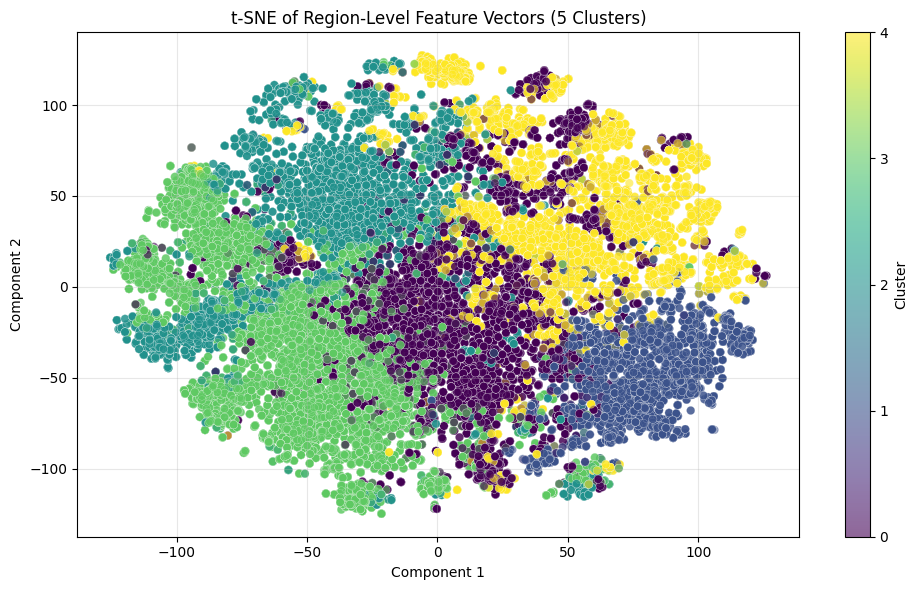


Cluster distribution for silent vectors:
 - Cluster 1: 1407 silent
 - Cluster 3: 3076 silent
 - Cluster 0: 2491 silent
 - Cluster 4: 2581 silent
 - Cluster 2: 1722 silent

Cluster distribution for annotated vectors:
 - Cluster 1: 3289 annotated
 - Cluster 3: 8024 annotated
 - Cluster 0: 7361 annotated
 - Cluster 4: 6250 annotated
 - Cluster 2: 6503 annotated


In [4]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from itertools import groupby
from operator import itemgetter
from collections import Counter

# === CONFIG ===
features_path = "MLPC2025_dataset/audio_features"           # <<-- CHANGE THIS
annotations_path = "MLPC2025_dataset/annotations.csv"       # <<-- CHANGE THIS
frame_duration = 0.96  # seconds per frame

# Top 15 features selected via PCA in step (a)
top_feature_indices = keep_indices  # <<-- Replace with your actual top PCA indices

# === Load Annotations ===
annotations = pd.read_csv(annotations_path)
X = []
y = []  # 1 = annotated, 0 = silent

region_meta = []

for filename, group in annotations.groupby("filename"):
    file_id = os.path.splitext(filename)[0]
    npz_path = os.path.join(features_path, f"{file_id}.npz")
    if not os.path.exists(npz_path):
        continue

    try:
        data = np.load(npz_path)

        # Full frame-level feature stack
        feature_stack = np.concatenate([
            data['embeddings'],                     # (n, 768)
            data['melspectrogram'],                 # (n, 64)
            data['mfcc'],                           # (n, 32)
            data['mfcc_delta'],                     # (n, 32)
            data['mfcc_delta2'],                    # (n, 32)
            data['flatness'],                       # (n, 1)
            data['centroid'],                       # (n, 1)
            data['flux'],                           # (n, 1)
            data['energy'],                         # (n, 1)
            data['power'],                          # (n, 1)
            data['bandwidth'],                      # (n, 1)
            data['contrast'],                       # (n, 7)
            data['zerocrossingrate']                # (n, 1)
        ], axis=1)

        # Select only top PCA-ranked features
        feature_stack = feature_stack[:, top_feature_indices]

        n_frames = feature_stack.shape[0]
        used = np.zeros(n_frames, dtype=bool)

        # Annotated regions
        for _, row in group.iterrows():
            onset = row["onset"]
            offset = row["offset"]
            start = int(onset / frame_duration)
            end = int(offset / frame_duration)
            start = max(0, start)
            end = min(n_frames, end)
            if start >= end:
                continue
            segment = feature_stack[start:end]
            X.append(segment.mean(axis=0))
            y.append(1)
            used[start:end] = True
            region_meta.append({
    "filename": filename,
    "onset": onset,
    "offset": offset,
    "is_annotated": True
})

        # Silent regions
        silent_indices = np.where(~used)[0]
        for k, g in groupby(enumerate(silent_indices), lambda ix: ix[0] - ix[1]):
            group_indices = list(map(itemgetter(1), g))
            if len(group_indices) >= 2:
                segment = feature_stack[group_indices]
                X.append(segment.mean(axis=0))
                y.append(0)
                onset = group_indices[0] * frame_duration
                offset = (group_indices[-1] + 1) * frame_duration
                region_meta.append({
                    "filename": filename,
                    "onset": onset,
                    "offset": offset,
                    "is_annotated": False
                })

    except Exception as e:
        print(f"Error with {filename}: {e}")

X = np.array(X)
X = scaler.fit_transform(X)
y = np.array(y)
print(f"Extracted {X.shape[0]} vectors with {X.shape[1]} selected features.")

# === Clustering ===
kmeans = KMeans(n_clusters=5, random_state=0)
cluster_labels = kmeans.fit_predict(X)

for i in range(len(region_meta)):
    region_meta[i]["cluster"] = cluster_labels[i]
region_df = pd.DataFrame(region_meta)

# === t-SNE Visualization ===
tsne = TSNE(n_components=2, perplexity=30, random_state=0)
coords = tsne.fit_transform(X)

plt.figure(figsize=(10, 6))
plt.scatter(coords[:, 0], coords[:, 1], 
            c=cluster_labels, 
            cmap='viridis', 
            alpha=0.6,   
            edgecolor='w', 
            linewidth=0.2)
plt.title("t-SNE of Region-Level Feature Vectors (5 Clusters)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Cluster", ticks=range(5))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# === Cluster Composition Analysis ===
silent_counts = Counter(cluster_labels[np.array(y) == 0])
annotated_counts = Counter(cluster_labels[np.array(y) == 1])

print("\nCluster distribution for silent vectors:")
for k, v in silent_counts.items():
    print(f" - Cluster {k}: {v} silent")

print("\nCluster distribution for annotated vectors:")
for k, v in annotated_counts.items():
    print(f" - Cluster {k}: {v} annotated")


In [5]:
print("\nCluster distribution for silent vectors:")
total_s = 0
total_a = 0
for k, v in silent_counts.items():
    print(f" - Cluster {k}: {v} silent")
    total_s += v

print("\nCluster distribution for annotated vectors:")
for k, v in annotated_counts.items():
    print(f" - Cluster {k}: {v} annotated")
    total_a += v
print(f"silent clusters: {total_s}")
print(f"annotated clusters: {total_a}")


Cluster distribution for silent vectors:
 - Cluster 1: 1407 silent
 - Cluster 3: 3076 silent
 - Cluster 0: 2491 silent
 - Cluster 4: 2581 silent
 - Cluster 2: 1722 silent

Cluster distribution for annotated vectors:
 - Cluster 1: 3289 annotated
 - Cluster 3: 8024 annotated
 - Cluster 0: 7361 annotated
 - Cluster 4: 6250 annotated
 - Cluster 2: 6503 annotated
silent clusters: 11277
annotated clusters: 31427


In [7]:
# Variance by feature group
embedding_var = np.var(all_frames[:, :768], axis=0).mean()
mel_var = np.var(all_frames[:, 768:832], axis=0).mean()
mfcc_var = np.var(all_frames[:, 832:864], axis=0).mean()
delta_mfcc_var = np.var(all_frames[:, 864:896], axis=0).mean()
delta2_mfcc_var = np.var(all_frames[:, 896:928], axis=0).mean()
flatness_var = np.var(all_frames[:, 928], axis=0).item()
centroid_var = np.var(all_frames[:, 929], axis=0).item()
flux_var = np.var(all_frames[:, 930], axis=0).item()
energy_var = np.var(all_frames[:, 931], axis=0).item()
power_var = np.var(all_frames[:, 932], axis=0).item()
bandwidth_var = np.var(all_frames[:, 933], axis=0).item()
contrast_var = np.var(all_frames[:, 934:941], axis=0).mean()
zcr_var = np.var(all_frames[:, 941], axis=0).item()

# Print or log the results
print("Mean Variance by Feature Group:")
print(f"  Embedding: {embedding_var:.6f}")
print(f"  Mel: {mel_var:.6f}")
print(f"  MFCC: {mfcc_var:.6f}")
print(f"  ΔMFCC: {delta_mfcc_var:.6f}")
print(f"  ΔΔMFCC: {delta2_mfcc_var:.6f}")
print(f"  Flatness: {flatness_var:.6f}")
print(f"  Centroid: {centroid_var:.6f}")
print(f"  Flux: {flux_var:.6f}")
print(f"  Energy: {energy_var:.6f}")
print(f"  Power: {power_var:.6f}")
print(f"  Bandwidth: {bandwidth_var:.6f}")
print(f"  Contrast: {contrast_var:.6f}")
print(f"  ZCR: {zcr_var:.6f}")

Mean Variance by Feature Group:
  Embedding: 0.164573
  Mel: 4.109024
  MFCC: 8.143231
  ΔMFCC: 0.037800
  ΔΔMFCC: 0.011851
  Flatness: 0.008108
  Centroid: 911897.752253
  Flux: 233.331093
  Energy: 27580.389500
  Power: 8344512.320979
  Bandwidth: 553391.980708
  Contrast: 21.883678
  ZCR: 0.015637


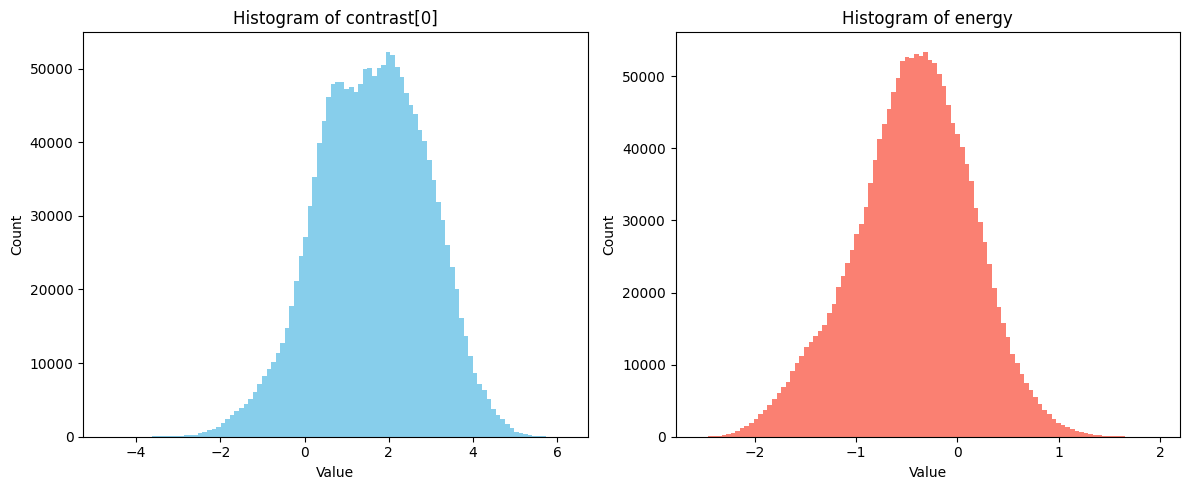

In [8]:
contrast5 = all_frames[:, 256]
energy = all_frames[:, 104]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(contrast5, bins=100, color='skyblue')
plt.title("Histogram of contrast[0]")
plt.xlabel("Value")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
plt.hist(energy, bins=100, color='salmon')
plt.title("Histogram of energy")
plt.xlabel("Value")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

In [9]:
for i in top_indices:
    print(f"{i}: {importance_scores[i]:.4f} — {interpret_index(i)}")

256: 0.0256 — embedding[256]
104: 0.0255 — embedding[104]
363: 0.0255 — embedding[363]
518: 0.0254 — embedding[518]
41: 0.0252 — embedding[41]
624: 0.0252 — embedding[624]
420: 0.0252 — embedding[420]
327: 0.0251 — embedding[327]
504: 0.0251 — embedding[504]
580: 0.0251 — embedding[580]
177: 0.0250 — embedding[177]
625: 0.0250 — embedding[625]
137: 0.0250 — embedding[137]
99: 0.0250 — embedding[99]
341: 0.0250 — embedding[341]
27: 0.0249 — embedding[27]
229: 0.0249 — embedding[229]
241: 0.0249 — embedding[241]
283: 0.0249 — embedding[283]
680: 0.0249 — embedding[680]
355: 0.0249 — embedding[355]
571: 0.0248 — embedding[571]
345: 0.0248 — embedding[345]
450: 0.0248 — embedding[450]
755: 0.0248 — embedding[755]
689: 0.0248 — embedding[689]
380: 0.0248 — embedding[380]
288: 0.0248 — embedding[288]
685: 0.0248 — embedding[685]
205: 0.0248 — embedding[205]
2: 0.0248 — embedding[2]
293: 0.0247 — embedding[293]
245: 0.0247 — embedding[245]
210: 0.0247 — embedding[210]
51: 0.0246 — embedding[5

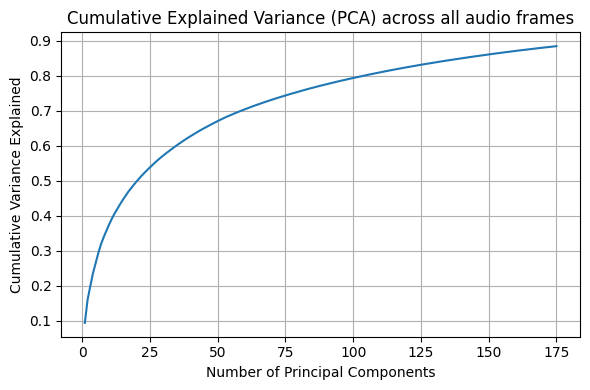

In [10]:
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(explained)+1), explained)
plt.title("Cumulative Explained Variance (PCA) across all audio frames")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Variance Explained")
plt.grid(True)
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'PCA Importance Scores by Feature Group')

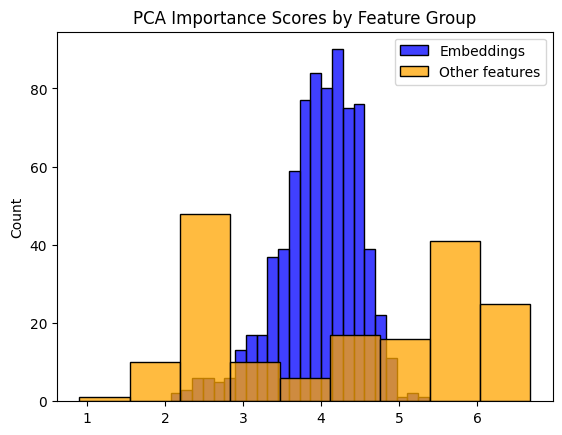

In [11]:
import seaborn as sns

loadings = np.abs(pca.components_)  # shape: (175, 942)
feature_scores = loadings.sum(axis=0)  # shape: (942,)

sns.histplot(feature_scores[:768], color='blue', label='Embeddings')
sns.histplot(feature_scores[768:], color='orange', label='Other features')
plt.legend()
plt.title("PCA Importance Scores by Feature Group")

In [12]:
# After PCA fitting (assuming standardized data)
loadings = np.abs(pca.components_) * pca.explained_variance_ratio_.reshape(-1, 1)
print(np.abs(pca.components_).shape)
print(pca.explained_variance_ratio_.shape)
print(pca.explained_variance_ratio_.reshape(-1, 1).shape)
embedding_loadings = loadings[:, :768]          # First 768 cols = embeddings
other_loadings = loadings[:, 768:]              # Remaining 174 cols = other features

# Calculate group-wise importance
embedding_importance = np.sum(np.abs(embedding_loadings))
other_importance = np.sum(np.abs(other_loadings))
print(f"Embeddings contribution: {embedding_importance:.2f}%")
print(f"Other features contribution: {other_importance:.2f}%")

(175, 942)
(175,)
(175, 1)
Embeddings contribution: 17.55%
Other features contribution: 2.66%


In [13]:
print(pca.components_.shape)

(175, 942)


In [14]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame({"cluster": cluster_labels, "silent": y == 0})
sns.countplot(data=df, x="cluster", hue="silent")


ValueError: All arrays must be of the same length